<a href="https://colab.research.google.com/github/cartmarsh/MachineLearning1/blob/main/breast_cancer_kaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Kaggle breast cancer competition

1. Download a part of the data
2. analyze it
3. structure it
4. create basic model
5. make prediction on submission data
6. submit first result on kaggle

7. Fine-Tuning (Todo: outline process, collect ideas to optimize)
  ..
  ..
  ..

## Download part of the data

In [2]:
import os

In [3]:
os.environ["KAGGLE_CONFIG_DIR"] = "/content"

In [4]:
%matplotlib inline
#magic command to show the matplotlib plots in the output cell of the notebook

#basic libraries
import pandas as pd
import numpy as np
import os

#visualisation libraries
import seaborn as sns
import matplotlib.pyplot as plt
from pandas_profiling import ProfileReport


In [5]:
!pip install kaggle --quiet

In [6]:
!chmod 600 /content/kaggle.json

chmod: cannot access '/content/kaggle.json': No such file or directory


In [ ]:
!kaggle competitions files rsna-breast-cancer-detection 

In [15]:
!kaggle competitions download rsna-breast-cancer-detection -f "test_images/10008/68070693.dcm" 
!kaggle competitions download rsna-breast-cancer-detection -f "test.csv" 
!kaggle competitions download rsna-breast-cancer-detection -f "train.csv" 

  0% 0.00/3.42M [00:00<?, ?B/s]
100% 3.42M/3.42M [00:00<00:00, 256MB/s]
  0% 0.00/239 [00:00<?, ?B/s]
100% 239/239 [00:00<00:00, 264kB/s]
  0% 0.00/556k [00:00<?, ?B/s]
100% 556k/556k [00:00<00:00, 143MB/s]


In [ ]:
!kaggle -h


In [17]:
!ls

68070693.dcm.zip  kaggle.json  sample_data  test.csv  train.csv.zip


In [18]:
!unzip "/content/68070693.dcm.zip"
!unzip "/content/train.csv.zip"


Archive:  /content/68070693.dcm.zip
  inflating: 68070693.dcm            
Archive:  /content/train.csv.zip
  inflating: train.csv               


In [19]:
!pip install pydicom --quiet

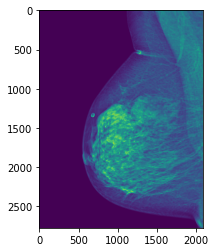

In [20]:
%matplotlib inline
import pydicom as dicom
import matplotlib.pylab as plt

# specify your image path
image_path = '/content/68070693.dcm'
ds = dicom.dcmread(image_path)

plt.imshow(ds.pixel_array)

In [21]:
train_raw = pd.read_csv("train.csv")
test_raw = pd.read_csv("test.csv")

In [22]:
train_raw.head()

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False
2,2,10006,1864590858,R,MLO,61.0,0,0,0,NaN,0,NaN,29,False
3,2,10006,1874946579,R,CC,61.0,0,0,0,NaN,0,NaN,29,False
4,2,10011,220375232,L,CC,55.0,0,0,0,0.0,0,NaN,21,True


In [23]:
train_raw.columns

Index(['site_id', 'patient_id', 'image_id', 'laterality', 'view', 'age',
       'cancer', 'biopsy', 'invasive', 'BIRADS', 'implant', 'density',
       'machine_id', 'difficult_negative_case'],
      dtype='object')

In [24]:
# General Libraries
import os
import re
import gc
import cv2
import random
import math
from glob import glob
from tqdm import tqdm
from pprint import pprint
from time import time
import datetime as dtime
from datetime import datetime
import itertools
import warnings
import pandas as pd
import numpy as np
import pydicom # for DICOM images
from skimage.transform import resize
from sklearn.preprocessing import LabelEncoder, normalize

In [25]:
!pip install -q efficientnet_pytorch

  Preparing metadata (setup.py) ... done


In [26]:
# PyTorch
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch import FloatTensor, LongTensor
from torch.utils.data import Dataset, DataLoader, Subset
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Data Augmentation for Image Preprocessing
from albumentations import (ToFloat, Normalize, VerticalFlip, HorizontalFlip, Compose, Resize,
                            RandomBrightnessContrast, HueSaturationValue, Blur, GaussNoise,
                            Rotate, RandomResizedCrop, Cutout, ShiftScaleRotate, ToGray)
from albumentations.pytorch import ToTensorV2

from efficientnet_pytorch import EfficientNet
from torchvision.models import resnet34, resnet50

# SKlearn
from sklearn.model_selection import StratifiedKFold, GroupKFold
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix

In [27]:
# Keep only columns in test + target variable
train = train_raw[["patient_id", "image_id", "laterality", "view", "age", "implant", "cancer"]]

# Encode categorical variables
le_laterality = LabelEncoder()
le_view = LabelEncoder()

train['laterality'] = le_laterality.fit_transform(train['laterality'])
train['view'] = le_view.fit_transform(train['view'])

train.head()

<ipython-input-27-d30812d8f0e8>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['laterality'] = le_laterality.fit_transform(train['laterality'])
<ipython-input-27-d30812d8f0e8>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['view'] = le_view.fit_transform(train['view'])


,patient_id,image_id,laterality,view,age,implant,cancer
0,10006,462822612,0,1,61.0,0,0
1,10006,1459541791,0,5,61.0,0,0
2,10006,1864590858,1,5,61.0,0,0
3,10006,1874946579,1,1,61.0,0,0
4,10011,220375232,0,1,55.0,0,0


In [28]:
print("Number of missing values in Age:", train["age"].isna().sum())
train['age'] = train['age'].fillna(58)

Number of missing values in Age: 37


<ipython-input-28-618da72afe28>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['age'] = train['age'].fillna(58)


In [37]:
train.columns[train.isna().any()].tolist()

[]

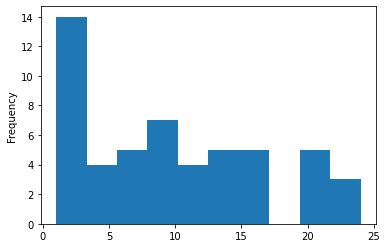

In [41]:
train["age"].value_counts().plot(kind="hist")


In [31]:
# Sample down for dev
train = train.sample(n=500, random_state=13).reset_index(drop=True)
train["cancer"].value_counts()

0    482
1     18
Name: cancer, dtype: int64

In [32]:
# ----- GLOBAL PARAMS -----
vertical_flip = 0.5
horizontal_flip = 0.5

csv_columns = ['laterality', 'view', 'age', 'implant']
no_columns = len(csv_columns)
output_size = 1
# -------------------------

## 3.1 Label Encoding
# laterality:
- 0: L (Left)
- 1: R (Right)
# view:
- 0: AT (axillary tail)
- 1: CC (craniocaudal)
- 2: LM (latero-medial)
- 3: LMO (latero-medial oblique)
- 4: ML (medio-lateral)
- 5: MLO (mediolateral oblique)

In [33]:
class RSNADataset(Dataset):
    
    def __init__(self, dataframe, vertical_flip, horizontal_flip,
                 is_train=True):
        self.dataframe, self.is_train = dataframe, is_train
        self.vertical_flip, self.horizontal_flip = vertical_flip, horizontal_flip
        
        # Data Augmentation (custom for each dataset type)
        if is_train:
            self.transform = Compose([RandomResizedCrop(height=224, width=224),
                                      ShiftScaleRotate(rotate_limit=90, scale_limit = [0.8, 1.2]),
                                      HorizontalFlip(p = self.horizontal_flip),
                                      VerticalFlip(p = self.vertical_flip),
                                      ToTensorV2()])
        else:
            self.transform = Compose([ToTensorV2()])
            
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, index):
        '''Take each row in batcj at a time.'''
         # Select path and read image
        image_path = self.dataframe['path'][index]
        image = pydicom.dcmread(image_path).pixel_array.astype(np.float32)
        
        # For this image also import .csv information
        csv_data = np.array(self.dataframe.iloc[index][csv_columns].values, 
                            dtype=np.float32)
        # Apply transforms
        transf_image = self.transform(image=image)['image']
        # Change image from 1 channel (B&W) to 3 channels
        transf_image = np.concatenate([transf_image, transf_image, transf_image], axis=0)
        
        # Return info
        if self.is_train:
            return {"image": transf_image, 
                    "meta": csv_data, 
                    "target": self.dataframe['cancer'][index]}
        else:
            return {"image": transf_image, 
                    "meta": csv_data}

In [34]:

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device available now:', DEVICE)

Device available now: cuda


## Sanity Check

In [42]:
def data_to_device(data):
    
    image, metadata, targets = data.values()
    return image.to(DEVICE), metadata.to(DEVICE), targets.to(DEVICE)

In [44]:
# Sample down for dev
train = train_raw.sample(n=500, random_state=13).reset_index(drop=True)
train["cancer"].value_counts()

0    482
1     18
Name: cancer, dtype: int64

In [ ]:
# ----- GLOBAL PARAMS -----
vertical_flip = 0.5
horizontal_flip = 0.5

csv_columns = ['laterality', 'view', 'age', 'implant']
no_columns = len(csv_columns)
output_size = 1
# -------------------------

In [47]:
# Sample data
sample_df = train.head(6)

# Instantiate Dataset object
dataset = RSNADataset(sample_df, vertical_flip, horizontal_flip,
                      is_train=True)
# The Dataloader
dataloader = DataLoader(dataset, batch_size=3, shuffle=False)

In [1]:
dataset

NameError: ignored

In [45]:
# Sample data
sample_df = train.head(6)

# Instantiate Dataset object
dataset = RSNADataset(sample_df, vertical_flip, horizontal_flip,
                      is_train=True)
# The Dataloader
dataloader = DataLoader(dataset, batch_size=3, shuffle=False)

# Output of the Dataloader
for k, data in enumerate(dataloader):
    image, meta, targets = data_to_device(data)
    print(clr.S + f"Batch: {k}" + clr.E, "\n" +
          clr.S + "Image:" + clr.E, image.shape, "\n" +
          clr.S + "Meta:" + clr.E, meta, "\n" +
          clr.S + "Targets:" + clr.E, targets, "\n" +
          "="*50)

KeyError: ignored